# Построение графика Gaussian - Gamma KLD

In [1]:
import numpy as np
from scipy import special
import math
from tqdm.auto import tqdm

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
class SeriesValue:
    def __init__(self, max_psi=100000):
        _, self.digamma = self.fill_psi_table(max_psi)
    
    
    @staticmethod
    def fill_psi_table(max_pis):
        psi = [-2*np.log(2) - np.euler_gamma]
        z = [0.5]
        for k in range(max_pis):
            z_i = z[-1]
            p_i = psi[-1] + 1/z_i
            z.append(z_i + 1)
            psi.append(p_i)
        z = np.array(z)
        psi = np.array(psi)
        return z, psi
    
    def get_log_terms(self, u, k):
        p = np.zeros(k.shape)
        mask = k < len(self.digamma)
        p[mask] = self.digamma[k[mask]]
        p[~mask] = np.log(k[~mask])  # аппроксимация digamma функции логорифмом
        v = -0.5*u**2 + 2*k*np.log(u) + np.log(p) - k*np.log(2) - special.loggamma(k + 1)
        return v
    
    def get_max_and_range(self, u):
        k_median = int(0.5*u**2) + 1
        dk = int(5.0*u)
        k_min = max(1, k_median - dk)
        k_max = k_median + dk
        return k_median, (k_min, k_max)
    
    def __call__(self, u):
        if np.isclose(u, 0):
            return 0.0
        k_median, (k_min, k_max) = self.get_max_and_range(u)
        k = np.arange(k_min, k_max+1)
        v = self.get_log_terms(u, k)
        
        v_max = np.max(v)
        dv = v - v_max
        fval = np.sum(np.exp(dv)) * np.exp(v_max)
        return fval

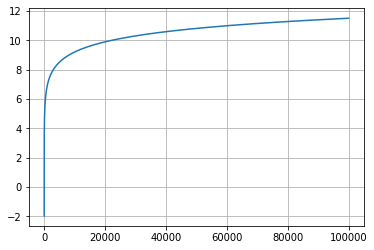

In [3]:
# Проверка того, что правильно получилась Дигамма функция
z, psi = SeriesValue.fill_psi_table(100000)
plt.plot(z, psi, label='digamma');
plt.grid(True);

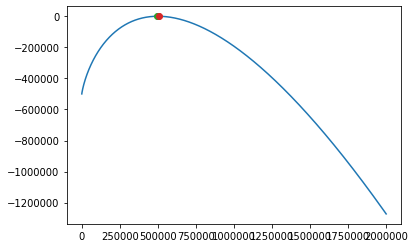

In [4]:
# Проверка того, что правильно строится кривая членов и находится ее максимум
series = SeriesValue(10000)
k = np.arange(1, 2000000)
u = 1000

v = series.get_log_terms(u, k)
k_median, (k_min, k_max) = series.get_max_and_range(u)
plt.plot(k, v);
for k in [k_median, k_min, k_max]:
    k = np.array([k])
    v = series.get_log_terms(u, k)
    plt.plot(k, v, 'o');

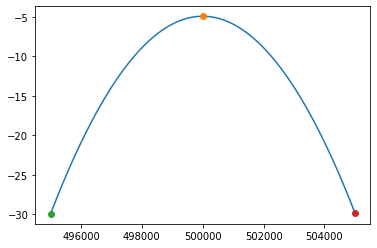

In [5]:
# Проверка того, что правильно находится диапазон не нулевых значений
series = SeriesValue(10000)

u = 1000
k_median, (k_min, k_max) = series.get_max_and_range(u)
k = np.arange(k_min, k_max+1)
v = series.get_log_terms(u, k)
plt.plot(k, v);
for k in [k_median, k_min, k_max]:
    k = np.array([k])
    v = series.get_log_terms(u, k)
    plt.plot(k, v, 'o');

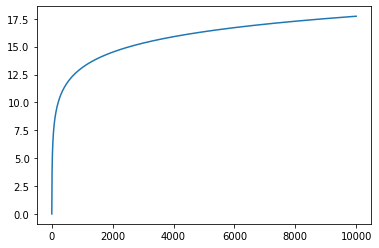

In [6]:
series = SeriesValue(100000)

u = np.linspace(0.0, 10000.0, 2000)
f = [series(ui) for ui in tqdm(u, leave=False)]
plt.plot(u, f)

In [7]:
series = SeriesValue(1000000)

def get_kld_const(alpha, beta):
    return (-0.5*np.log(math.pi*math.exp(1)/2.0) + special.loggamma(alpha) - alpha*math.log(beta) 
            + 0.5*(1-alpha)*math.log(2))

def get_kld(alpha, beta, sigma, u):
    c0 = get_kld_const(alpha, beta)
    # c0 = 0.0
    c1 = -alpha*np.log(sigma)
    c2 = np.exp(-0.5*u**2)*(math.sqrt(2/math.pi)*beta*sigma - 0.5*(1-alpha)*(2.0*np.log(2)+np.euler_gamma))
    c3 = beta*sigma*u*special.erf(u/np.sqrt(2))
    c4 = np.array([series(ui) for ui in tqdm(u, leave=False)])
    c4 *= 0.5*(1-alpha)
    return c0 + c1 + c2 + c3 + c4

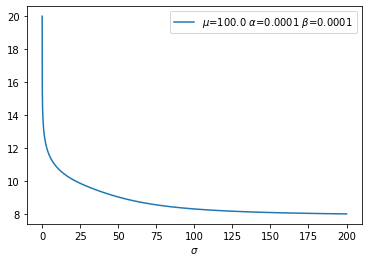

In [8]:
alpha = 0.0001
beta = 0.0001
mu = 100.0
sigma = np.linspace(0.001, 200, 2000)

u = mu / sigma
v = get_kld(alpha, beta, sigma, u)

plt.plot(sigma, v, label=r'$\mu$=' + str(mu) + r' $\alpha$=' + str(alpha) + r' $\beta$=' + str(beta));
plt.xlabel('$\sigma$');

plt.legend();

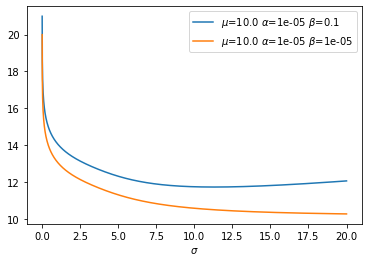

In [9]:
alpha = 1.e-5
beta = 1e-1
mu = 10.0
sigma = np.linspace(0.001, 20, 2000)

u = mu / sigma
v = get_kld(alpha, beta, sigma, u)

plt.plot(sigma, v, label=r'$\mu$=' + str(mu) + r' $\alpha$=' + str(alpha) + r' $\beta$=' + str(beta));
plt.xlabel('$\sigma$');

alpha = 1.e-5
beta = 1e-5


u = mu / sigma
v = get_kld(alpha, beta, sigma, u)

plt.plot(sigma, v, label=r'$\mu$=' + str(mu) + r' $\alpha$=' + str(alpha) + r' $\beta$=' + str(beta));
plt.legend();

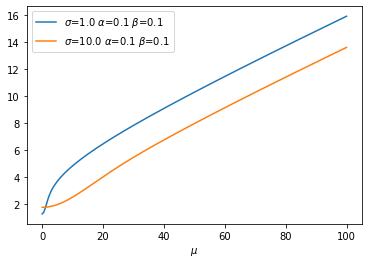

In [11]:
alpha = 1e-1
beta = 1e-1
mu = np.linspace(0.0, 100, 200)

sigma = 1.0

u = mu / sigma
v = get_kld(alpha, beta, sigma, u)

plt.plot(mu, v, label=r'$\sigma$=' + str(sigma) + r' $\alpha$=' + str(alpha) + r' $\beta$=' + str(beta));
plt.xlabel('$\mu$');

sigma = 10.0

u = mu / sigma
v = get_kld(alpha, beta, sigma, u)

plt.plot(mu, v, label=r'$\sigma$=' + str(sigma) + r' $\alpha$=' + str(alpha) + r' $\beta$=' + str(beta));
plt.legend();